In [1]:
import numpy as np
import torch as th
import qepsilon as qe
from qepsilon import *
from task import *
from matplotlib import pyplot as plt
import time
from task import RamseyScan, RamseySpinEcho, RamseyXY8

## do not print the tensor in scientific notation
th.set_printoptions(sci_mode=False, precision=3)
dev = 'cuda'

## Define the one qubit system with initial state $|\downarrow\rangle$

In [2]:
batchsize = 24000
qubit = qe.QubitLindbladSystem(n_qubits=1, batchsize=batchsize)
qubit.set_rho_by_config([0])
qubit.to(dev)


## load trained model

In [3]:
conf = th.load('state_dict.pt', weights_only=True)
conf_keys = [x for x in conf]
conf_paras = {}
for key in conf_keys:
    if conf[key].shape == th.tensor(1).shape:
        conf_paras[key] = conf[key]

print(conf_paras)
sz_noise_shot_amp = float(th.exp(conf_paras['_hamiltonian_operator_group_dict.sz_noise_shot.logamp']))
sz_noise_color_amp = float(th.exp(conf_paras['_hamiltonian_operator_group_dict.sz_noise_color.logamp']))
sz_noise_color_tau = float(th.exp(conf_paras['_hamiltonian_operator_group_dict.sz_noise_color.logtau']))
sz_noise_60hz_amp = float(th.exp(conf_paras['_hamiltonian_operator_group_dict.sz_noise_60hz.logamp']))
sz_noise_120hz_amp = float(th.exp(conf_paras['_hamiltonian_operator_group_dict.sz_noise_120hz.logamp']))
sz_noise_180hz_amp = float(th.exp(conf_paras['_hamiltonian_operator_group_dict.sz_noise_180hz.logamp']))
sz_noise_240hz_amp = float(th.exp(conf_paras['_hamiltonian_operator_group_dict.sz_noise_240hz.logamp']))
sx_jump = float(conf_paras['_jumping_group_dict.sx_jump.coef'])
sz_jump = float(conf_paras['_jumping_group_dict.sz_jump.coef'])
depol_p = conf_paras['_channel_group_dict.depol_channel._p']
depol_p = float(th.tanh(depol_p)+1)/2.0


{'_hamiltonian_operator_group_dict.sz_noise_shot.logamp': tensor(-1.220), '_hamiltonian_operator_group_dict.sz_noise_color.logtau': tensor(1.298), '_hamiltonian_operator_group_dict.sz_noise_color.logamp': tensor(-2.874), '_hamiltonian_operator_group_dict.sz_noise_60hz.logamp': tensor(-3.296), '_hamiltonian_operator_group_dict.sz_noise_60hz.logtau': tensor(2.813), '_hamiltonian_operator_group_dict.sz_noise_120hz.logamp': tensor(-2.730), '_hamiltonian_operator_group_dict.sz_noise_120hz.logtau': tensor(2.120), '_hamiltonian_operator_group_dict.sz_noise_180hz.logamp': tensor(-3.775), '_hamiltonian_operator_group_dict.sz_noise_180hz.logtau': tensor(1.715), '_hamiltonian_operator_group_dict.sz_noise_240hz.logamp': tensor(-2.155), '_hamiltonian_operator_group_dict.sz_noise_240hz.logtau': tensor(1.427), '_jumping_group_dict.sx_jump.coef': tensor(0.032), '_jumping_group_dict.sz_jump.coef': tensor(0.034), '_channel_group_dict.depol_channel._p': tensor(-4.053)}


## Define noise terms in the time-dependent Hamiltonian

In [4]:
sz_shot = ShotbyShotNoisePauliOperatorGroup(n_qubits=1, id="sz_noise_shot", batchsize=batchsize, amp=sz_noise_shot_amp, requires_grad=False).to(dev)
sz_shot.add_operator('Z')
qubit.add_operator_group_to_hamiltonian(sz_shot)

sz0 = LangevinNoisePauliOperatorGroup(n_qubits=1, id="sz_noise_color", batchsize=batchsize, tau=sz_noise_color_tau, amp=sz_noise_color_amp, requires_grad=False).to(dev)
sz0.add_operator('Z')
qubit.add_operator_group_to_hamiltonian(sz0)

sz1 = PeriodicNoisePauliOperatorGroup(n_qubits=1, id="sz_noise_60hz", batchsize=batchsize, tau=(1000/60 ), amp=sz_noise_60hz_amp, requires_grad=False).to(dev)
sz1.add_operator('Z')
qubit.add_operator_group_to_hamiltonian(sz1)

sz2 = PeriodicNoisePauliOperatorGroup(n_qubits=1, id="sz_noise_120hz", batchsize=batchsize, tau=(1000/120), amp=sz_noise_120hz_amp, requires_grad=False).to(dev)
sz2.add_operator('Z')
qubit.add_operator_group_to_hamiltonian(sz2)

sz3 = PeriodicNoisePauliOperatorGroup(n_qubits=1, id="sz_noise_180hz", batchsize=batchsize, tau=(1000/180), amp=sz_noise_180hz_amp, requires_grad=False).to(dev)
sz3.add_operator('Z')
qubit.add_operator_group_to_hamiltonian(sz3)

sz4 = PeriodicNoisePauliOperatorGroup(n_qubits=1, id="sz_noise_240hz", batchsize=batchsize, tau=(1000/240), amp=sz_noise_240hz_amp, requires_grad=False).to(dev)
sz4.add_operator('Z')
qubit.add_operator_group_to_hamiltonian(sz4)

## Define the time-indepedent Jump operators in the Lindblad equation

In [5]:
sx_jump = StaticPauliOperatorGroup(n_qubits=1, id="sx_jump", batchsize=batchsize, coef=sx_jump, static=True,requires_grad=False).to(dev)
sx_jump.add_operator('X')
qubit.add_operator_group_to_jumping(sx_jump)

sz_jump = StaticPauliOperatorGroup(n_qubits=1, id="sz_jump", batchsize=batchsize, coef=sz_jump, static=True, requires_grad=False).to(dev)
sz_jump.add_operator('Z')
qubit.add_operator_group_to_jumping(sz_jump)

## Define the error channel associated with each control pulse $R_{\vec{n}}(\theta)$

In [6]:
depol_channel = DepolarizationChannel(n_qubits=1, id="depol_channel", batchsize=batchsize, p=depol_p, requires_grad=False).to(dev)
qubit.add_operator_group_to_channel(depol_channel)

## Load one-molecule experimental data from [Science 382.6675 (2023): 1143-1147.]

In [11]:
preparation_rate = 0.824
## load csv data
data_plain = np.loadtxt('./Data/Fig3C_GreenTriangles.csv', delimiter=',', skiprows=1)
data_echo = np.loadtxt('./Data/Fig3C_RedSquares.csv', delimiter=',', skiprows=1)
data_XY8 = np.loadtxt('./Data/Fig3C_BlueCircles.csv', delimiter=',', skiprows=1)


## Run a long simulations with the productive model

In [8]:
with th.no_grad():
    plain_t = np.linspace(0,10,51)
    Ramsey_Plain_P0 = RamseyScan(qubit, dt=0.01, T=10, theta_list=[0, np.pi], observe_at=plain_t)
    Ramsey_Plain_Contrast = th.abs(Ramsey_Plain_P0[:, 1] - Ramsey_Plain_P0[:, 0])
    
    ## Ramsey experiment with echo
    echo_t = np.linspace(0,160,41)
    contrast = []
    for T in echo_t:
        Ramsey_Echo_P0 = RamseySpinEcho(qubit, dt=0.05, T=T, theta_list=[0, np.pi])
        contrast.append(th.abs(Ramsey_Echo_P0[1] - Ramsey_Echo_P0[0]))
    Ramsey_Echo_Contrast = th.stack(contrast)
    
    ## Ramsey experiment with XY8 sequence
    xy8_t = np.linspace(0,240,121)
    Ramsey_XY8_P0 = RamseyScan_XY8(qubit, dt=0.1, T=240, cycle_time=XY8_cycle_time, theta_list=[0, np.pi], observe_at=xy8_t)
    Ramsey_XY8_Contrast = th.abs(Ramsey_XY8_P0[:, 1] - Ramsey_XY8_P0[:, 0])
np.save('Data/DIQCD_Ramsey_Plain_Contrast', Ramsey_Plain_Contrast.detach().cpu().numpy())
np.save('Data/DIQCD_Ramsey_Echo_Contrast', Ramsey_Echo_Contrast.detach().cpu().numpy())
np.save('Data/DIQCD_Ramsey_XY8_Contrast', Ramsey_XY8_Contrast.detach().cpu().numpy())


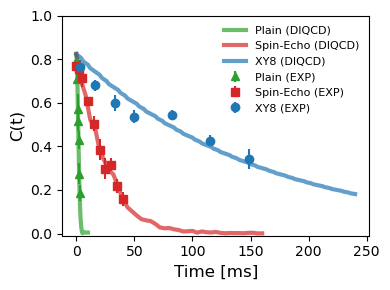

In [28]:
fig, ax = plt.subplots(1,1, figsize=(4, 3))
## Plain scheme
ax.plot(plain_t, Ramsey_Plain_Contrast.detach().cpu().numpy() * preparation_rate, label='Plain (DIQCD)', color='tab:green', linewidth=3, alpha=0.7)
ax.errorbar(data_plain[:,0], data_plain[:, 1],  data_plain[:, 2], marker='^', color='tab:green', label='Plain (EXP)', linestyle='None') 
## Spin Echo
ax.plot(echo_t, Ramsey_Echo_Contrast.detach().cpu().numpy() * preparation_rate, label='Spin-Echo (DIQCD)', color='tab:red', linewidth=3, alpha=0.7)
ax.errorbar(data_echo[:, 0], data_echo[:, 1], data_echo[:, 2], marker='s', color='tab:red', label='Spin-Echo (EXP)', linestyle='None')
## XY8, cycle time 1.6ms
ax.plot(xy8_t, Ramsey_XY8_Contrast.detach().cpu().numpy() * preparation_rate, label='XY8 (DIQCD)', color='tab:blue', linewidth=3, alpha=0.7)
ax.errorbar(data_XY8[:, 0], data_XY8[:, 1], data_XY8[:, 2], marker='o', color='tab:blue', label='XY8 (EXP)', linestyle='None')
## 
ax.set_xlabel('Time [ms]',fontsize=12)
ax.set_ylabel('C(t)', fontsize=12)
ax.set_ylim(-0.01,1)
ax.legend(fontsize=8, frameon=False)
plt.tight_layout()
plt.savefig('one-body.png', dpi=300)
plt.show()
plt.close()